## Predictor - Corrector Interior Point Method for Support Vector Classification

Support Vector Machine is essentially a constrained convex quadratic optimzation problem.

In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.linalg import ldl
import scipy.linalg
from sklearn.datasets import make_moons, make_circles, make_classification

In [2]:
def _cvxopt(x, z, y, s, G, g, C, d, A, b, eta, maxk):
    
    path = []
    path.append(x)
    
    #compute the residuals
    mA, nA = A.shape[0], A.shape[1]
    
    mC, nC = C.shape[0], C.shape[1]
    
    e = np.matrix(np.ones((nC,1)))
    
    rL = G*x + g - A*y - C*z
    rA = -A.T*x + b
    rC = -C.T*x + s + d
    rsz = np.multiply(s,z)
    mu = np.sum(np.multiply(z,s))/nC
    
    # number of iteration, epsilon, tolerance
    
    k = 0
    #maxk = 2000
    eps_L = 1e-10
    eps_A = 1e-10
    eps_C = 1e-10
    eps_mu = 1e-10
    
    while (k <= maxk):# and np.linalg.norm(rL)>=eps_L and np.linalg.norm(rA)>=eps_A and np.linalg.norm(rC)>=eps_C and abs(rsz).all()>=eps_mu):
    
        
        # solve the sytem of equation : predictor step
        
        lhs = np.block([[G,-A,-C],[-A.T,np.zeros((nA,nA)),np.zeros((nA,nC))],[-C.T,np.zeros((nC,nA)),-np.diag((s/z).A1)]])
        
        #L, D, P = ldl(lhs)
        
        #L, D, P = np.matrix(L), np.matrix(D), np.matrix(np.eye(len(L))[:,P])
        
        rhs = np.block([[-rL],[-rA],[-rC + rsz/z]])
        
        dxyz_a = np.linalg.solve(lhs,rhs)
        #dxyz_a = P*(np.linalg.inv(L.T)*(np.linalg.inv(D)*(np.linalg.inv(L)*(P.T*rhs))))
        
        dx_a = dxyz_a[0:len(x)]
        dy_a = dxyz_a[len(x):len(y)+len(x)]
        dz_a = dxyz_a[len(y)+len(x):len(x)+len(y)+len(z)]        
        ds_a = -((rsz + np.multiply(s,dz_a))/z)
        
        # compute alpha_aff
        
        alpha_a = 1
        
        idx_z = np.nonzero(dz_a < 0)
        
        if (len(idx_z[0])!=0):
            alpha_a =  min(alpha_a, np.min(-z[idx_z]/dz_a[idx_z]))
            
        idx_s = np.where(ds_a < 0)
        
        if (len(idx_s[0])!=0):
            alpha_a =  min(alpha_a, np.min(-s[idx_s]/ds_a[idx_s]))
        
        mu_a = ((z + alpha_a*dz_a).T*(s + alpha_a*ds_a))/nC
        
        sigma = np.linalg.matrix_power(mu_a/mu,3)
        
    
        # solve the sytem of equation : corrector step
        
        rsz = rsz + np.multiply(ds_a,dz_a) - sigma[0,0]*mu*e
        rhs = np.block([[-rL],[-rA],[-rC + rsz/z]])
        dxyz = np.linalg.solve(lhs,rhs)
        #dxyz = P*(np.linalg.inv(L.T)*(np.linalg.inv(D)*(np.linalg.inv(L)*(P.T*rhs))))
        
        dx = dxyz[0:len(x)]
        dy = dxyz[len(x):len(y) + len(x)]
        dz = dxyz[len(y) + len(x):len(x) + len(y) + len(z)]
        ds = -((rsz + np.multiply(s,dz))/z)        
        
        # compute alpha
        
        alpha = 1
        
        idx_z = np.where(dz < 0)
        
        if (len(idx_z[0])!=0):
            alpha =  min(alpha, np.min(-z[idx_z]/dz[idx_z]))
            
        idx_s = np.where(ds < 0)
        
        if (len(idx_s[0])!=0):
            alpha =  min(alpha, np.min(-s[idx_s]/ds[idx_s]))
            
        # Update x, z, s
        
        #print(alpha)
        x = x + eta*np.multiply(alpha,dx)
        z = z + eta*np.multiply(alpha,dz)
        y = y + eta*np.multiply(alpha,dy)
        s = s + eta*np.multiply(alpha,ds)
        
        k = k+1
    
        # Update rhs and mu
        
        rL = G*x + g - A*y - C*z
        rA = -A.T*x + b
        rC = -C.T*x + s + d
        rsz = np.multiply(s,z)
        mu = np.sum(np.multiply(z,s))/nC
        
        path.append(x)
        
    return x, path, k

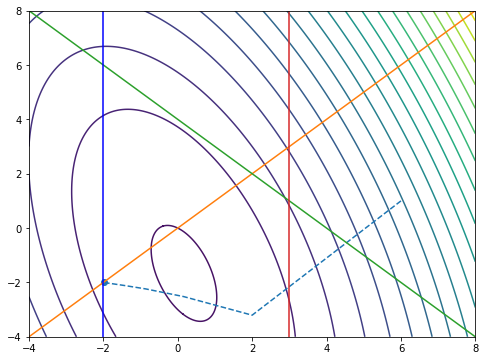

In [141]:
G = np.matrix([[8, 2],[2,2]])
g = np.matrix([[2],[3]])
C = np.matrix([[1,-1,-1],[-1,-1,0]])
x, y = np.matrix([[6],[1]]), np.matrix([[1]]) 
z, s = np.matrix([[1],[1],[1]]),np.matrix([[1],[1],[1]])
d = np.matrix([[0],[-4],[-3]])
A = np.matrix([[1],[0]])
b = np.matrix([[-2]])

eta = 0.5
maxk = 10
w, path, k = _cvxopt(x, z, y, s, G, g, C, d, A, b, eta, maxk)

pathList = []

for ele in path: 
    pathList.append([ele[0,0],ele[1,0]])
    
pathListStacked = np.vstack(pathList)

x = np.linspace(-4,8, 1000)
x2 = np.linspace(3,3, 1000)
y = np.linspace(-4,8, 1000)
y2 = np.linspace(-4,8, 1000)
x3 = np.linspace(-2,-2, 1000)
y3 = np.linspace(-4,8, 1000)

def f(x1,x2):
    
    f = 2*x1 + 3*x2 + 4*x1**2 + 2*x1*x2 + x2**2
    
    return f

c1 = x
c2 = -x + 4
c3 = (1 - x)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)


plt.figure(figsize=(8,6))
plt.plot(pathListStacked[:,0],pathListStacked[:,1],'--')
plt.plot(x,c1)
plt.plot(x,c2)
plt.plot(x2,y2)
plt.plot(x3,y3, color = 'b')
plt.scatter(pathListStacked[len(pathListStacked)-1,0],pathListStacked[len(pathListStacked)-1,1])
plt.contour(X, Y, Z,20)
#plt.clabel(cnts, inline=True, fontsize=8)

In [3]:
# Kernel for Kernel Martrix creation
def kernel(x, type, gamma):
    
    Ndim = x.shape[0]
    
    if type == 'linear':
        
        K = np.dot(x,x.T)
    
    if type == 'rbf':
        
        K = np.dot(x,x.T)
        
        K = (np.diag(K).T*np.ones((1,Ndim)).T).T + np.diag(K).T*np.ones((1,Ndim)).T - 2*K
        
        K = np.exp(-gamma*K)
        
    return K 

In [4]:
# Kernel for classification
def kernelClass(x, z, type, gamma):
    
    Ndim = x.shape[0]
    
    if type == 'linear':
        
        K = np.dot(z,x.T)
    
    if type == 'rbf':
        
        K = np.dot(x,x.T)
        
        K = np.diag(K) + np.dot(z,z)*np.ones((1,K.shape[0])) - 2*np.dot(z,x.T)
        
        K = np.exp(-gamma*K)
        
    return K 

In [5]:
def Intercept_Calculation(w, X, target, sv):
    
    b = 0

    for SupportVectors in sv[0]:
    
        b = b + target[SupportVectors] - np.sum(np.array(w.T)[0]*target*np.dot(X,X[SupportVectors].T).T)
    
    b = b/len(sv)
    
    return b

In [6]:
def Classify(x, z, target, w, b, type, gamma):    
    
    Threshold = np.sum(w*target*kernelClass(x, z, type, gamma)) + b

    if Threshold > 0:
        
        return 1
    else:
        
        return -1

In [7]:
def plot(x, target, w,b, type, gamma, X, y):
    xx = np.linspace(min(X[:,0])-0.1, max(X[:,0])+0.1, 100)
    yy = np.linspace(min(X[:,1])-0.3, max(X[:,1])+0.3, 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.array(np.vstack([XX.ravel(), YY.ravel()]).T)
    pred=[0]*len(xy)
    pred=np.array(pred)
        
    for i in range(0,len(xy)):

        pred[i] = Classify(x,xy[i,:].reshape(1,-1)[0], target, w,b, type, gamma)
        
    Z = pred.reshape(XX.shape)
    f = plt.figure(figsize=(14,5))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.scatter(X[:, 0], X[:, 1], s=50,c=y)
    plt.subplot(122)
    ax2.contourf(XX, YY, Z,cmap=plt.cm.coolwarm,alpha=0.9)
    ax2.scatter(X[:, 0], X[:, 1], s=50,c=y)
    plt.show()

In [36]:
def svm(X, yTarget, type, gamma, c, slack):
    
    N = X.shape[0]
    K = kernel(X, type, gamma)
    
    # Create the matrices
    G = np.multiply(np.matrix(target).T*np.matrix(target),K)
    g = -np.matrix(np.ones((N,1)))
    C = np.matrix(np.block([[-np.eye(N)],[np.eye(N)]])).T
    d = np.matrix(np.block([[-c*np.ones((N,1))],[0*np.ones((N,1))]]))
    A = np.matrix(target.reshape(N,1))
    b = np.matrix([[0]])
    x = np.matrix([[0]*N]).T
    y = np.matrix([[0.1]]).T
    z = np.matrix([[0.1]*len(C.T)]).T
    s = np.matrix([[0.1]*len(C.T)]).T
    
    # run optimiation
    eta = 0.9  #step length
    maxk = 20 # maximum iterations
    w, path, k = _cvxopt(x, z, y, s, G, g, C, d, A, b, eta,maxk)
    sv = np.where(w >= slack)
    
    plt.scatter(X[:,0],X[:,1], s = 50,c=yTarget)
    plt.scatter(X[sv[0],0],X[sv[0],1], s = 50,marker = 'x')
    
    # ger support vectors
    Xs = X[sv[0],:]
    
    #get intercept
    bInt = Intercept_Calculation(w, X, target, sv)
    
    #plot decision boundry
    plot(Xs, yTarget[sv[0]],np.array(w[sv[0],:]).T[0],0, type, gamma, X, yTarget)

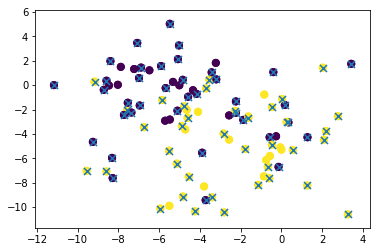

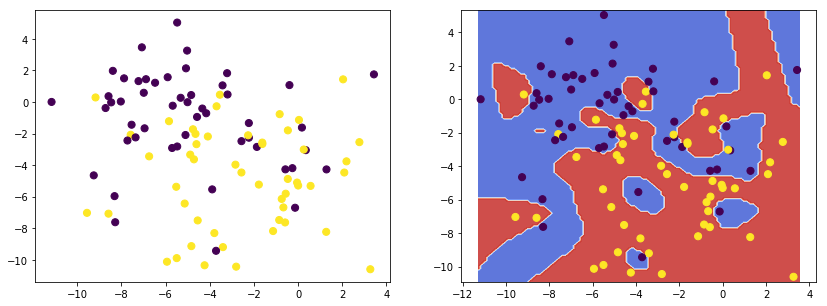

In [39]:
X, target = make_blobs(n_samples=100, centers=2, random_state = 33, cluster_std=3)
target[np.where(target==0.0)]=-1

plt.scatter(X[:, 0], X[:, 1], s=50,c=target)

svm(X, target, 'rbf', 1,10, 0.1)

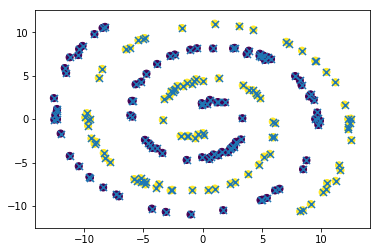

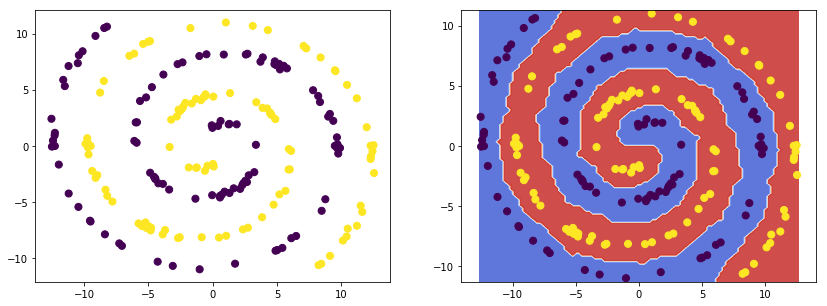

In [41]:
def twospirals(n_points, noise=0.5):
    
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, target = twospirals(100)
target[np.where(target==0.0)]=-1

svm(X, target, 'rbf', 10, 100, 0.1)

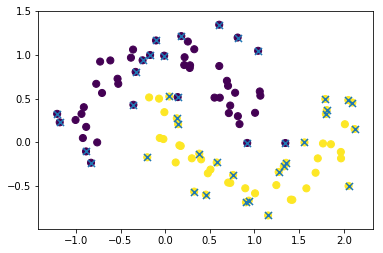

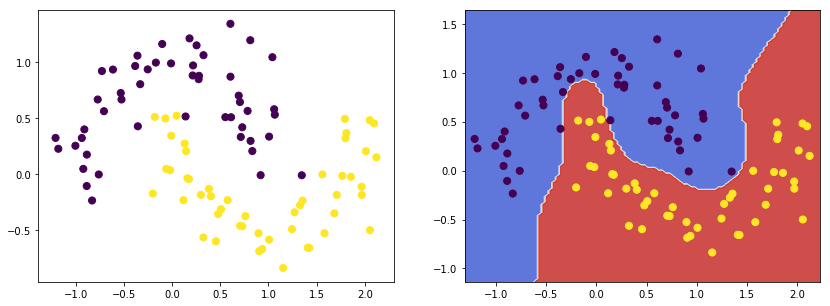

In [55]:
X, target = make_moons(noise=0.2, random_state=0)
target[np.where(target==0.0)]=-1

svm(X, target, 'rbf',5, 100,1e-01)